# Chi squared test for under-dispersion

## Set-up

In [1]:
# external imports
from IPython.display import display
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# local import
import plotting
from common import ATTITUDINAL, VOTING_INTENTION, ensure, MIDDLE_DATE
from data_capture import retrieve

In [2]:
SHOW = True

In [3]:
## Plotting initialisation
def set_up_plotting() -> None:
    """Set up plotting."""

    p = plotting.get_chart_dir()
    plotting.set_chart_dir(p + '/chi-squared/')
    plotting.clear_chart_dir()


set_up_plotting()

## Get data

In [4]:
data = retrieve()
ensure(data, "You must run the data capture notebook every day.")

In [5]:
# Double check that our voting intention data has been normalized ...
# Ideally, this cell will show nothing is wrong.

checkable = "Primary", "2pp"
vi = data[VOTING_INTENTION]
for check in checkable:
    columns = [c for c in vi.columns if check in c and "Other" not in c]
    check_these = vi[columns]
    row_sum = check_these.sum(axis=1)
    fail = check_these[(row_sum > 100.01) | (row_sum < 99.99)].copy()
    if len(fail):
        fail["TOTAL"] = row_sum
        display(fail)

In [6]:
# Amalgamate the ONP, UAP and OTH columns
vi = plotting.amalgamate_other(data[VOTING_INTENTION])

# let's look at the Primary Vote column names ...
[x for x in vi.columns if "Primary vote" in x]

['Primary vote L/NP',
 'Primary vote ALP',
 'Primary vote GRN',
 'Primary vote ONP',
 'Primary vote TOP',
 'Primary vote OTH',
 'Primary vote UAP',
 'Primary vote Other']

## Perform test

Series mean: 52.535829959514174


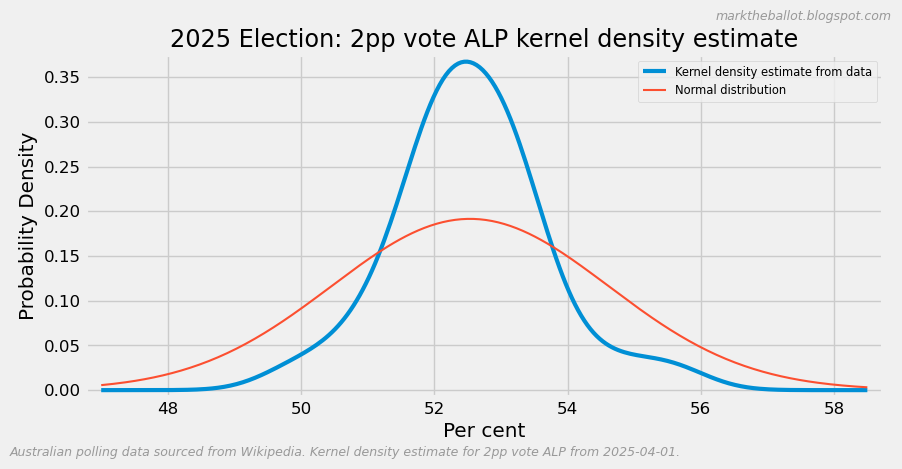

X^2 statistic:  9.641959650224553
Confidence interval: 95%
Expected X^2 between:  13.12  and  40.65
Probability:  0.002490751486874271
1/Probability:  401.48525666642644


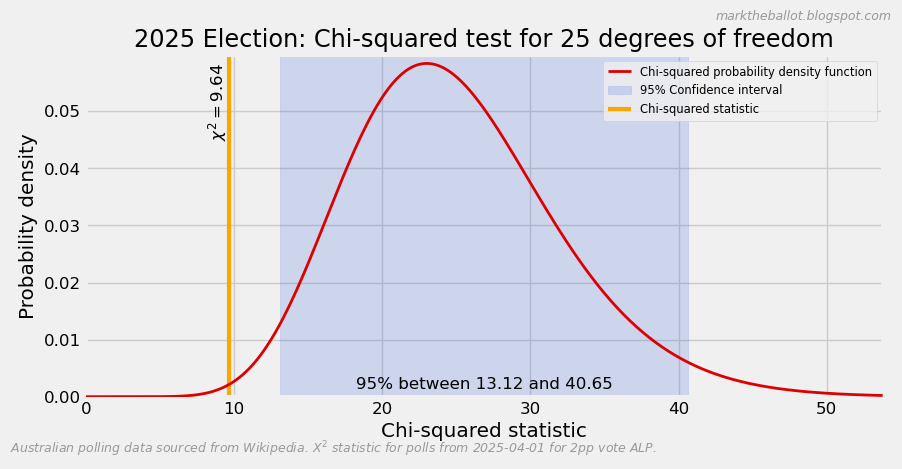

X^2 statistic:  9.641959650224553
Confidence interval: 99%
Expected X^2 between:  10.52  and  46.93
Probability:  0.002490751486874271
1/Probability:  401.48525666642644


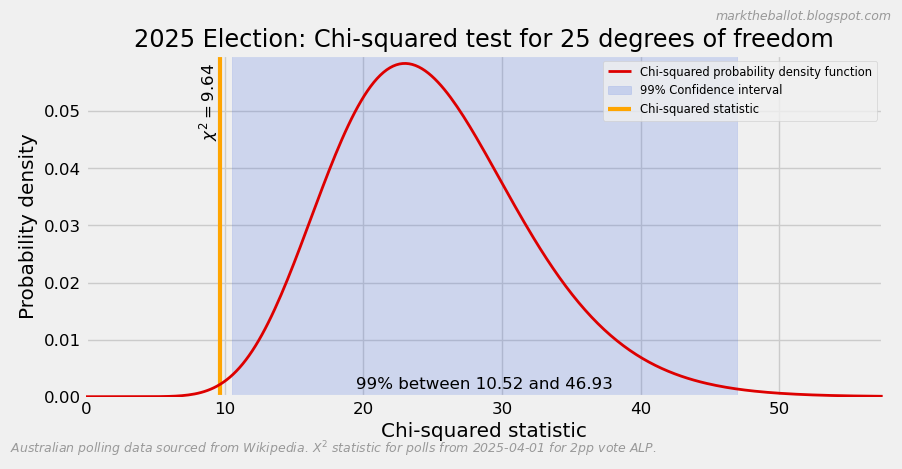

In [7]:
def calc_chi_2_statistic(
    data: pd.DataFrame,
    column: str,
    cut_off_date: str,
    title_stem: str,
) -> tuple[float, int]:
    """Calculate the chi-squared statistic for the given column in the data.
    Args:
        data (pd.DataFrame): The data to test, indexed by date as a day PeriodIndex.
        column (str): The name of the column to test.
        cut_off_date (str): The date to cut off the data.
    Returns:
        tuple: The chi-squared statistic and the degrees of freedom."""

    # Calculate the chi-squared statistic
    series = data.loc[data[MIDDLE_DATE] >= cut_off_date][column].dropna().astype(float)
    print(f'Series mean: {series.mean()}')
    sample_size = data.loc[series.index]['Sample size']
    poll_variance = (series * 100-series) / sample_size
    standard_dev = poll_variance ** 0.5
    dof = len(series) - 1
    X_squared = ((series - series.mean())/standard_dev).pow(2).sum()

    # plot a kernel density for the input data
    kde = stats.gaussian_kde(series)
    x_range = np.linspace(min(series) - 3, max(series) + 3, 250)
    kde_values = kde(x_range)
    sample_est = 1200
    std_dev = ((series.mean() * 100-series.mean()) / sample_est) ** 0.5
    normal = stats.norm.pdf(x_range, loc=series.mean(), scale=std_dev)
    fig, ax = plt.subplots()
    ax.plot(x_range, kde_values, lw=3, label='Kernel density estimate from data')
    ax.plot(x_range, normal, lw=1.5, label='Normal distribution')
    plotting.finalise_plot(
        ax,
        title=f'{title_stem}: {column} kernel density estimate',
        xlabel='Per cent',
        ylabel='Probability Density',
        rheader=plotting.footers["rfooter"],
        lfooter=plotting.footers["lfooter"]
        + f'Kernel density estimate for {column} from {cut_off_date}. ',
        legend={'loc': 'best', 'fontsize': 'x-small'},
        tag=f"-{column}-kde",
        show=SHOW,
    )

    return X_squared, dof


def calc_chi_pdf(
    dof: int,
    confidence: float,
    X_squared: float,
) -> tuple[pd.Series, float, float, float]:
    """Calculate the chi-squared probability density function for the given 
    degrees of freedom and idenidy the confidence interval.
    Args:
        dof (int): The degrees of freedom.
        confidence (float): The confidence level in the range 0 < confidence < 100.
        X_squared (float): The chi-squared statistic.
    Returns:
        tuple: The chi-squared probability density function, the lower and upper
        bounds of the confidence interval, and the probability of the chi-squared
        statistic."""

    lower = (1 - confidence/100) / 2.0
    upper = 1 - lower
    X_min = stats.distributions.chi2.ppf(lower, df=dof)
    X_max = stats.distributions.chi2.ppf(upper, df=dof)
    X_probability = stats.chi2.cdf(X_squared , dof)

    x = np.linspace(0, X_min + X_max, 250)
    X_pdf = pd.Series(stats.distributions.chi2(dof).pdf(x), index=x)
    return X_pdf, X_min, X_max, X_probability


def plot_chi(
    dof: int,
    X_squared: float,
    X_pdf: pd.Series,
    X_min: float,
    X_max: float,
    confidence: float,
    cut_off_date: str,
    title_stem: str,
    column: str,
) -> None:
    """Plot the chi-squared probability density function and the confidence interval.
    Args:
        dof (int): The degrees of freedom.
        X_squared (float): The chi-squared statistic.
        X_pdf (pd.Series): The chi-squared probability density function.
        X_min (float): The lower bound of the confidence interval.
        X_max (float): The upper bound of the confidence interval.
        confidence (float): The confidence level in the range 0 < confidence < 100."""

    ax = X_pdf.plot(c="#dd0000", lw=2, zorder=100, label='Chi-squared probability density function')
    ax.axvspan(X_min, X_max, color='royalblue', alpha=0.2, label=f'{confidence}% Confidence interval')
    ax.axvline(X_squared, color='orange', lw=3, label='Chi-squared statistic')
    ax.text(
        x=(X_min+X_max)/2, 
        y=X_pdf.max() * 0.015, 
        s=f'{confidence}% between {X_min:.2f} and {X_max:.2f}',
        ha='center', 
        va='bottom',
    )
    ax.text(
        x=X_squared, 
        y=X_pdf.max(), 
        s='$\chi^2 = '+str(round(X_squared, 2))+'$', 
        ha='right',
        va='top', 
        rotation=90
    )

    plotting.finalise_plot(
        ax, 
        title=f'{title_stem}: Chi-squared test for {dof} degrees of freedom',
        xlabel='Chi-squared statistic',
        ylabel='Probability density',
        xlim=(0, max(X_min + X_max, X_squared + 1)),
        ylim=(0, X_pdf.max() * 1.025),
        rheader=plotting.footers["rfooter"],
        lfooter=plotting.footers["lfooter"]
        + f'$X^2$ statistic for polls from {cut_off_date} for {column}. ',
        legend={'loc': 'best', 'fontsize': 'x-small'},
        tag=f"-{column}-{confidence}",
        show=SHOW,
    )


def run_chi_2_test(
    data: pd.DataFrame = vi,
    column: str = "2pp vote ALP",
    cut_off_date: str = "2025-04-01",
    confidences: tuple[float|int] = (95, 99),
    title_stem: str = "2025 Election",
) -> None:
    """Chi-squared test for the given column in the data.
    Args:
        data (pd.DataFrame): The data to test.
        column (str): The name of the column to test.
        cut_off_date (str): The date to cut off the data."""

    X_squared, dof = calc_chi_2_statistic(data, column, cut_off_date, title_stem)

    for confidence in confidences:
        # calculate the confidence interval and probability 
        X_pdf, X_min, X_max, X_probability = calc_chi_pdf(dof, confidence, X_squared)

        # print the results
        print('X^2 statistic: ', X_squared)
        print(f'Confidence interval: {confidence}%')
        print('Expected X^2 between: ', round(X_min, 2), ' and ', round(X_max, 2))
        print('Probability: ', X_probability)
        print('1/Probability: ', 1 / X_probability)

        plot_chi(
            dof, 
            X_squared,
            X_pdf, 
            X_min, 
            X_max, 
            confidence, 
            cut_off_date, 
            title_stem,
            column, 
        )


run_chi_2_test()

## Primary Votes

Series mean: 32.187953015118424


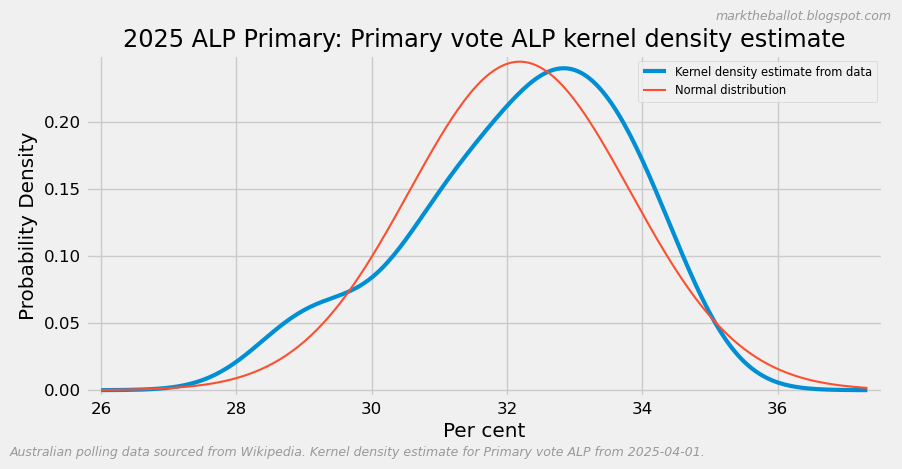

X^2 statistic:  33.13061557915792
Confidence interval: 95%
Expected X^2 between:  13.12  and  40.65
Probability:  0.8721652128362312
1/Probability:  1.1465717564543276


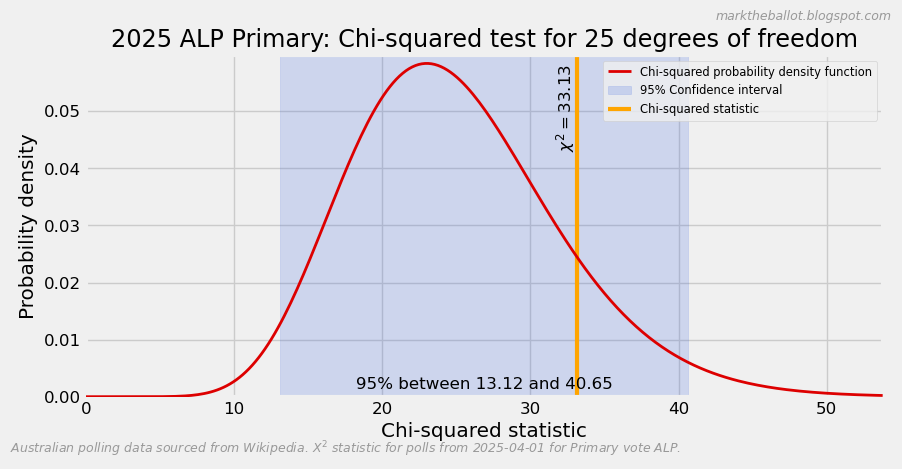

Series mean: 33.99863029024517


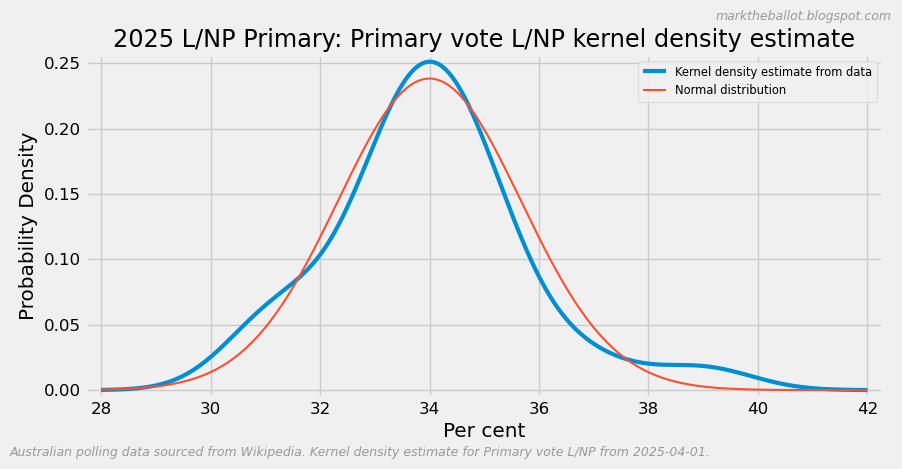

X^2 statistic:  34.94888128475792
Confidence interval: 95%
Expected X^2 between:  13.12  and  40.65
Probability:  0.910867794919935
1/Probability:  1.0978541623462488


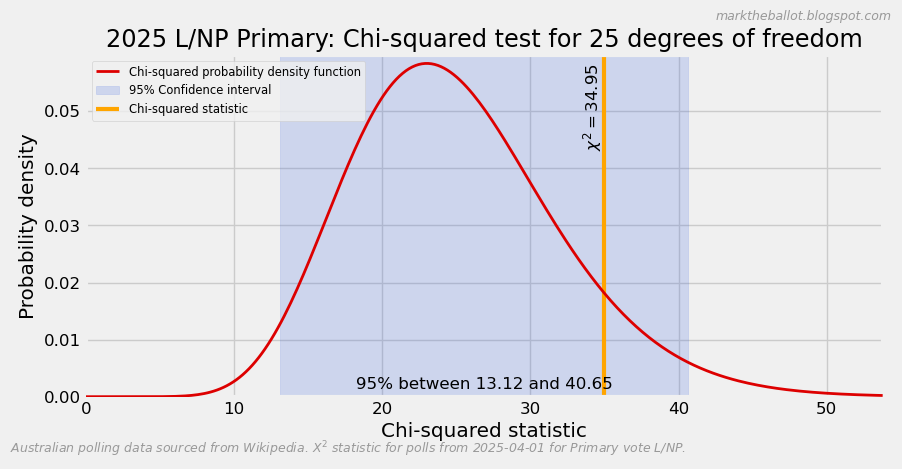

Series mean: 13.002784363048669


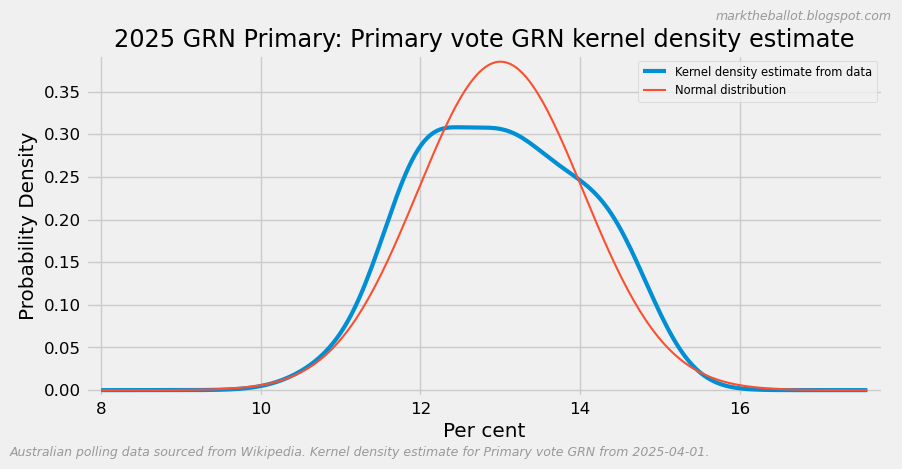

X^2 statistic:  34.415033977307104
Confidence interval: 95%
Expected X^2 between:  13.12  and  40.65
Probability:  0.9006697872688985
1/Probability:  1.1102848281747082


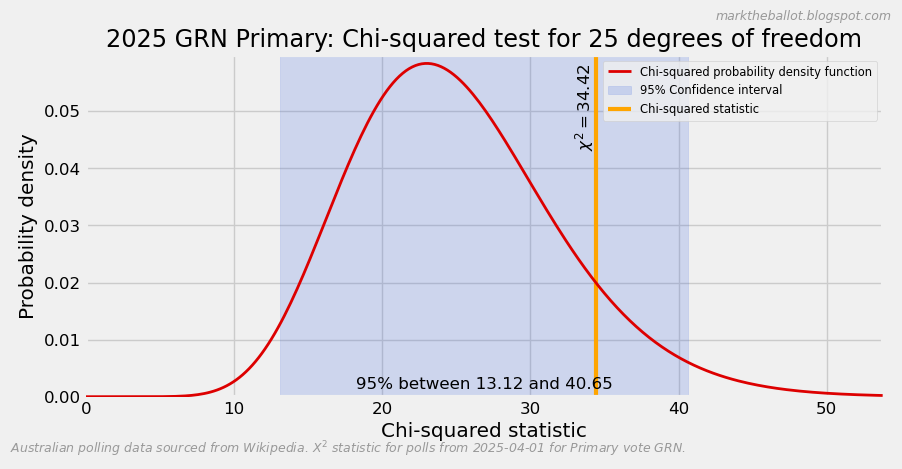

Series mean: 7.90827183778865


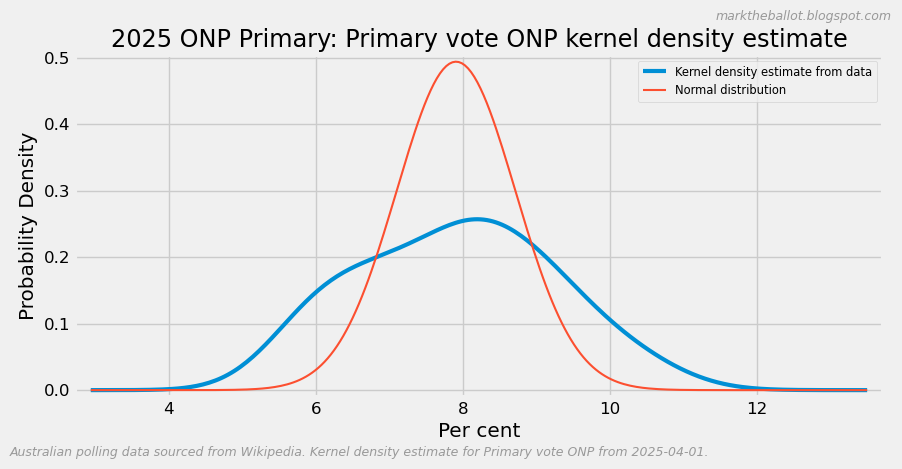

X^2 statistic:  94.22116680425786
Confidence interval: 95%
Expected X^2 between:  12.4  and  39.36
Probability:  0.9999999997146674
1/Probability:  1.0000000002853326


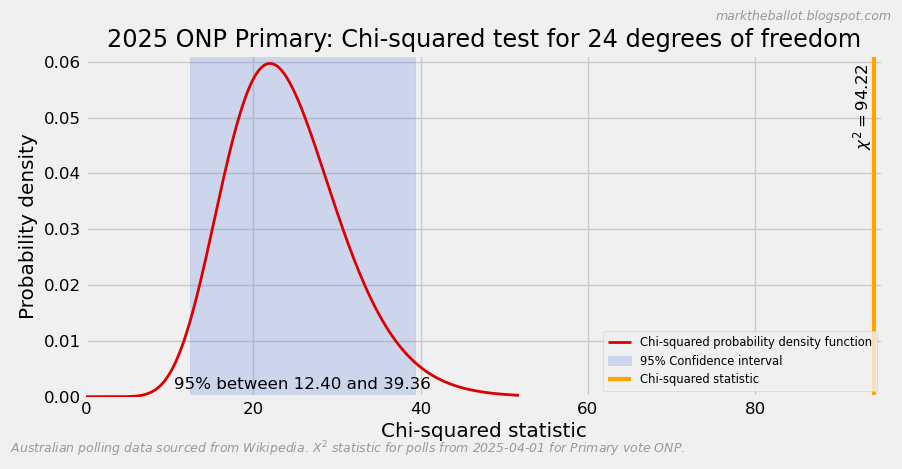

Series mean: 20.810632331587744


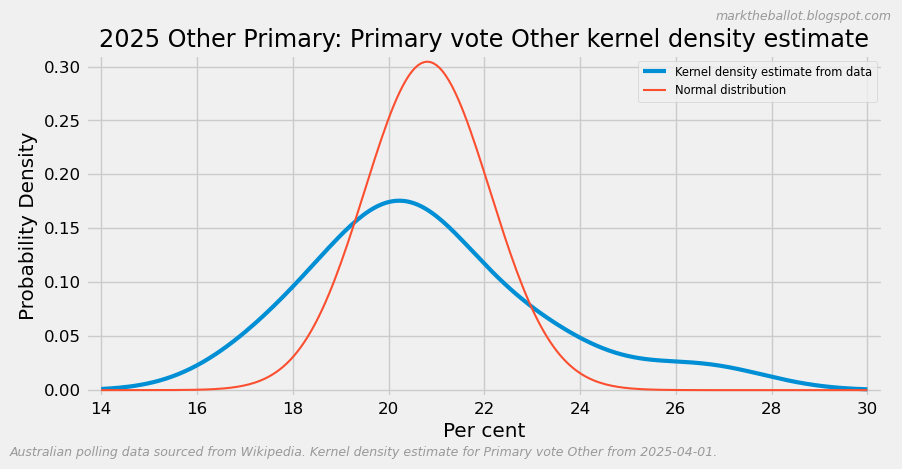

X^2 statistic:  115.75234892720952
Confidence interval: 95%
Expected X^2 between:  13.12  and  40.65
Probability:  0.9999999999998767
1/Probability:  1.0000000000001235


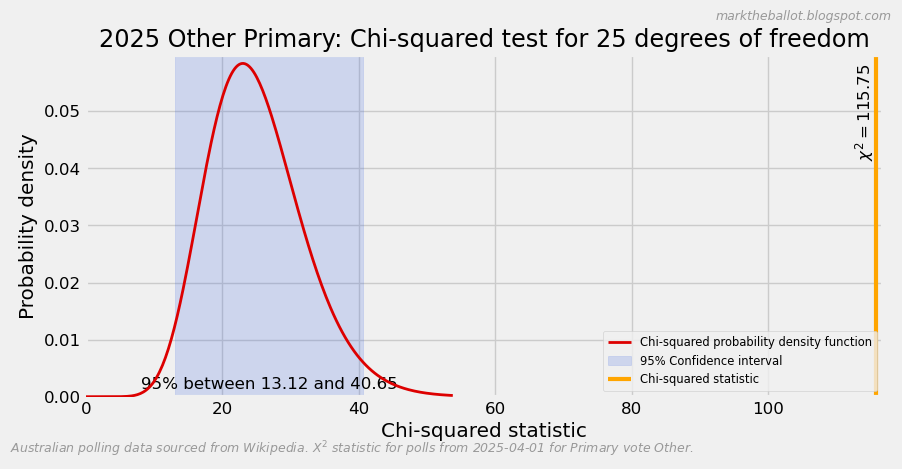

In [8]:
primaries = [
    "Primary vote ALP",
    "Primary vote L/NP",
    "Primary vote GRN",
    'Primary vote ONP',
    "Primary vote Other",
]
for col in primaries:
    run_chi_2_test(
        data=vi,
        column=col,
        cut_off_date="2025-04-01",
        confidences=(95,),
        title_stem=f"2025 {col.split()[-1]} Primary",
    )

## 2019 Redux

Series mean: 51.375


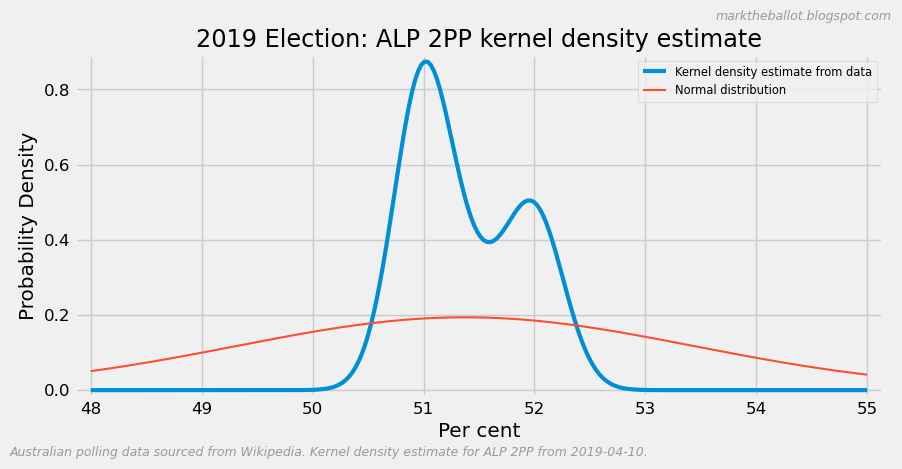

X^2 statistic:  0.6361926135448409
Confidence interval: 95%
Expected X^2 between:  6.26  and  27.49
Probability:  1.0007938824463894e-08
1/Probability:  99920674.73030023


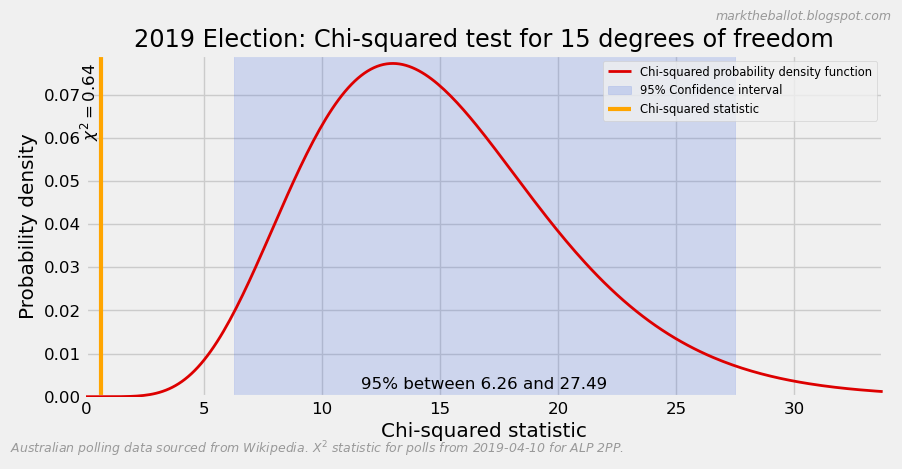

X^2 statistic:  0.6361926135448409
Confidence interval: 99%
Expected X^2 between:  4.6  and  32.8
Probability:  1.0007938824463894e-08
1/Probability:  99920674.73030023


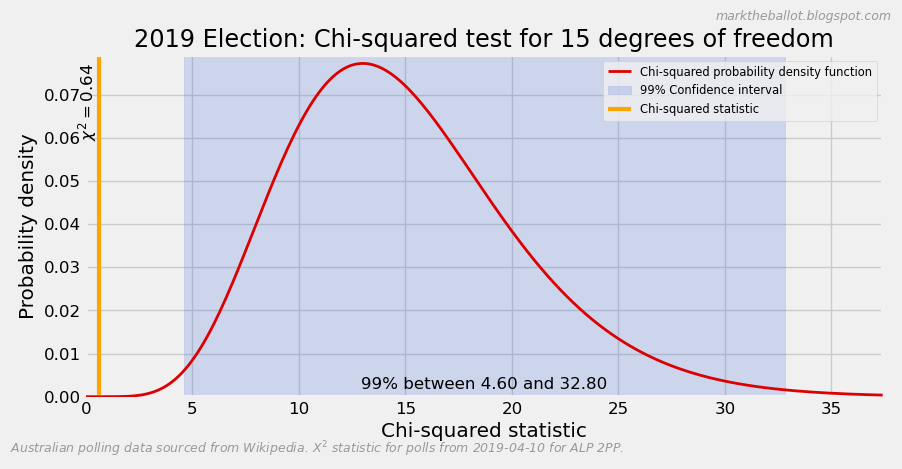

X^2 statistic:  0.6361926135448409
Confidence interval: 99.99%
Expected X^2 between:  2.16  and  46.17
Probability:  1.0007938824463894e-08
1/Probability:  99920674.73030023


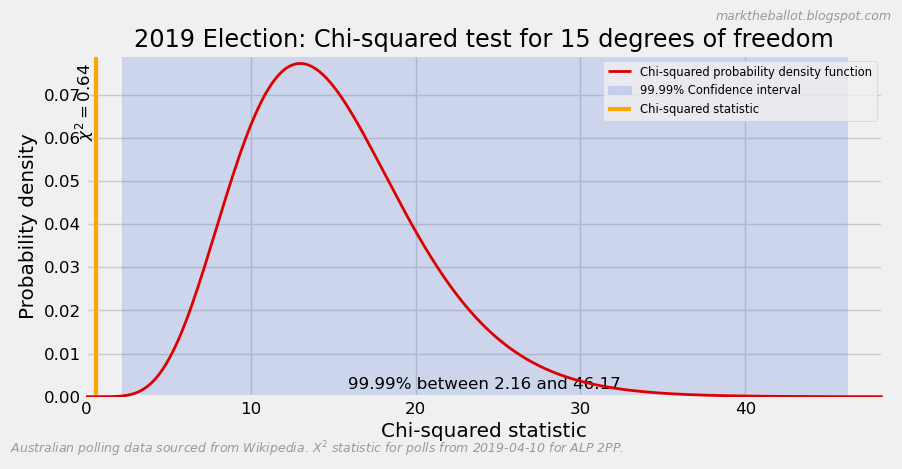

In [9]:
df = pd.read_csv("../historic-data/Election-2019.csv")
df[MIDDLE_DATE] = pd.PeriodIndex(df[MIDDLE_DATE], freq="D")
df['Sample size'] = 1000  # assume 1000 sample size
run_chi_2_test(
    data=df,
    column="ALP 2PP",
    cut_off_date="2019-04-10",
    confidences=(95, 99, 99.99),
    title_stem="2019 Election",
)

## Finished

In [10]:
%load_ext watermark
%watermark --python --machine --iversions --watermark

Python implementation: CPython
Python version       : 3.13.3
IPython version      : 9.2.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pandas    : 2.2.3
numpy     : 2.2.5
IPython   : 9.2.0
scipy     : 1.15.2
matplotlib: 3.10.1

Watermark: 2.5.0



In [11]:
print("Finished")

Finished
